In [1]:
## This file contains training code to learn the vision encoding to weights
## Author : Avadesh Meduri
## Date : 1/06/2022

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import time
import pathlib
from matplotlib import pyplot as plt
python_path = pathlib.Path('.').absolute().parent/'python'
os.sys.path.insert(1, str(python_path))

In [2]:
import numpy as np
import torch
from torch.autograd import Function
from torch.nn import functional as F
from torch.utils import data
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler, Sampler
from vocam.inverse_qp import IOC

from IPython.display import display, clear_output


import time
import numpy as np
import pinocchio as pin
from robot_properties_kuka.config import IiwaConfig

import meshcat
import meshcat.transformations as tf
import meshcat.geometry as g

In [3]:
class EncodingDataSet(Dataset):
    
    def __init__(self, indices):
        

        for i in range(len(indices)):
            if i == 0:
                self.x_train = torch.load("../data/x_traine2e_" + str(indices[i]) + ".pt")
                self.y_train = torch.load("../data/y_traine2e_" + str(indices[i]) + ".pt")
        
            else:
                x_train = torch.load("../data/x_traine2e_" + str(indices[i]) + ".pt")
                y_train = torch.load("../data/y_traine2e_" + str(indices[i]) + ".pt")
                
                self.x_train = torch.vstack((self.x_train, x_train))
                self.y_train = torch.vstack((self.y_train, y_train))

        # detaching is important to prevent camplaint on auto diff
        self.x_train = self.x_train.detach().float()
        self.y_train = self.y_train.detach().float()

        print("dataset size", len(self.x_train), len(self.y_train))

    def get_nn_size(self):
        return self.x_train.shape[1], self.y_train.shape[1]
    
    def __len__(self):
        return int(len(self.y_train))
    
    def __getitem__(self, gidx):
        
        return self.x_train[gidx], self.y_train[gidx]
    
    def getitem(self, gidx):
        
        return self.x_train[gidx], self.y_train[gidx]

In [4]:
class QPNet(nn.Module):
    def __init__(self, input_size, output_size):
        # game params
        super().__init__()
        
        self.swish = nn.SiLU()
        self.fc1 = nn.Linear(input_size, 512)
        self.bn1 = nn.BatchNorm1d(512)

        self.fc2 = nn.Linear(512, 1024)
        self.bn2 = nn.BatchNorm1d(1024)

        self.fc3 = nn.Linear(1024, 512)
        self.bn3 = nn.BatchNorm1d(512)

        self.dropout = nn.Dropout(p=0.5)

        self.out = nn.Linear(512, output_size)
        
    def forward(self, x):
        if len(x.shape) == 1:
            x = x[None, :]
        x = self.swish(self.bn1(self.fc1(x)))
        x = self.dropout(self.swish(self.bn2(self.fc2(x)))) 
        x = self.swish(self.bn3(self.fc3(x)))
        x = self.out(x)

        return x

    def save(self, path):
        torch.save(self.state_dict(), path)

    def load(self, path, device='cpu'):
        self.load_state_dict(torch.load(path, map_location=torch.device(device)))

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print("using cpu")
    device = torch.device("cpu")

lr = 1.0e-3
eps = 150
indices = [1,2]
test_indices = [3]

train_dataset = EncodingDataSet(indices)
# mean, std = train_dataset.get_mean_std()
inp, out = train_dataset.get_nn_size()
test_dataset = EncodingDataSet(test_indices)
net = QPNet(inp, out)
net_name = "e2eNet6"

# net.load_state_dict(torch.load("./models/" + net_name))
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# loss = torch.nn.L1Loss() #torch.nn.HuberLoss()
loss = torch.nn.MSELoss()

data = DataLoader(train_dataset, \
                  batch_size = 64, num_workers = 12, shuffle=True)
test = DataLoader(test_dataset, \
                  batch_size = 128, num_workers = 12, shuffle=True)

using cpu
dataset size 46820 46820
dataset size 1780 1780


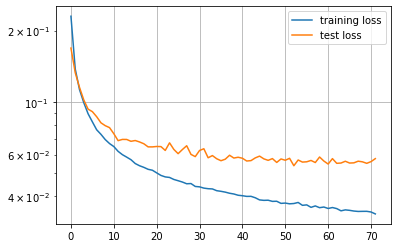

KeyboardInterrupt: 

In [6]:
best_loss = 1e3
last_save = 0
loss_arr = []
test_arr = []
for i in range(eps):
    m_e = []
    for x_train_batch, y_train_batch in data:
#         x_train_batch[:,14:] += 0.005*torch.randn(x_train_batch[:,14:].shape)
        x_train_gpu = x_train_batch.to(device)
        y_train_gpu = y_train_batch.to(device)
        y_pred = net(x_train_gpu)
        error = loss(y_pred, y_train_gpu) 
        m_e.append(error.cpu().detach().numpy())
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
    
    m_error = np.mean(m_e)
    loss_arr.append(m_error)

    t_e = []
    for x_test_batch, y_test_batch in test:
        x_test_gpu = x_test_batch.to(device)
        y_test_gpu = y_test_batch.to(device)
        y_pred = net(x_test_gpu)
        error = loss(y_pred, y_test_gpu) 
        t_e.append(error.cpu().detach().numpy())
    
    t_error = np.mean(t_e)
    test_arr.append(t_error)

    #plotting
    plt.plot(loss_arr, label = "training loss")
    plt.plot(test_arr, label = "test loss")

    plt.yscale("log")
    plt.grid()
    plt.legend()
    clear_output(wait=True)
    plt.show()
  
    print("The iteration number : " + str(i) + " The loss is :" + str(m_error) + \
                          " Last save :"  + str(last_save), end='\r', flush  = True)    
    
    
    if best_loss > m_error:
        last_save = i
        torch.save(net.state_dict(), "../models/" + net_name)
        best_loss = m_error
#     if i == 200:
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr/10)
#     if i == 400:
#         optimizer = torch.optim.Adam(net.parameters(), lr=lr/20)

        
torch.save(net.state_dict(), "./models/" + net_name)   